In [1]:
DATA_PATH    = '../../sevir_data_copy/data'
CATALOG_PATH = '../../sevir_data_copy/CATALOG.csv' 


In [2]:
import joblib
import cv2
import numpy as np
from matplotlib import pyplot as plot
from tqdm import tqdm
import os
# On some Linux systems setting file locking to false is also necessary:
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE' 
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
import pandas as pd
from sevir.display import get_cmap
import matplotlib

In [3]:
def read_data( sample_event, img_type, data_path=DATA_PATH ):
    """
    Reads single SEVIR event for a given image type.
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    img_type   str
        SEVIR image type
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array
       LxLx49 tensor containing event data
    """
    fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
    fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
    if(type(fn) is not pd.Series):
        with h5py.File(data_path + '/' + fn,'r') as hf:
            data=hf[img_type][fi] 
        return data
    else:
        return None
def convert_to_norm_cmap(sevir_np_data, sevir_dtype):
    #print(sevir_np_data[:,:,0])
    cmap,norm,vmin,vmax = get_cmap(sevir_dtype)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
    #print(norm)
    new_data = cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)
    #print(new_data)
    #print(sm.to_rgba(sevir_np_data).shape)
    return cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)

In [4]:
SEVIR_ID = "S840618"
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)
# Desired image types
img_types = set(['vis','ir069','ir107','vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())
print('Found %d events matching' % len(event_ids),img_types)
sample_event = events.get_group(SEVIR_ID)


Found 12739 events matching {'ir069', 'ir107', 'vis', 'vil'}


In [5]:
ir069 = read_data(sample_event, "ir069")

In [6]:
ir069 = np.transpose(ir069,(2,0,1))
ir069_color = np.array([convert_to_norm_cmap(ir069[i], "ir069") for i in range(ir069.shape[0])])
ir069_normed = np.array([matplotlib.colors.Normalize()(ir069[i]) for i in range(ir069.shape[0])])

In [91]:
vis = read_data(sample_event, "vis")
cmap,norm,vmin,vmax = get_cmap("vis")
vis = np.transpose(vis,(2,0,1))
vis_color = np.array([convert_to_norm_cmap(vis[i], "vis") for i in range(ir069.shape[0])])
vis_normed = np.array([cv2.resize(norm(vis[i]),(192,192)) for i in range(vis.shape[0])])

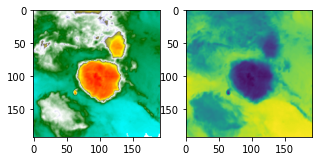

In [36]:
fig,axs = plt.subplots(1,2,figsize=(5,5))
axs[0].imshow(ir069_color[32])
axs[1].imshow(ir069_normed[32])

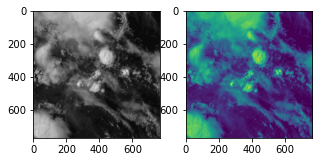

In [84]:
fig,axs = plt.subplots(1,2,figsize=(5,5))
axs[0].imshow(vis_color[10])
axs[1].imshow(vis_normed[10])

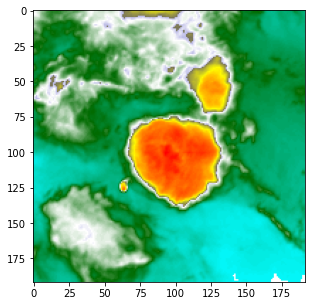

In [38]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(convert_to_norm_cmap(ir069_normed[32], "ir069"))

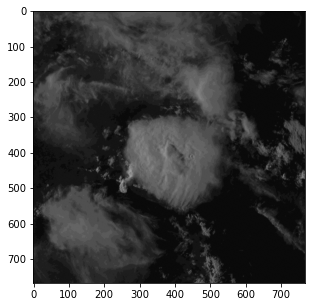

In [42]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(cmap(vis_normed[32]))

In [85]:
import rainymotion
from rainymotion.models import Dense, DenseRotation

model = Dense()
model.input_data = np.array(ir069_normed[0:49//2+10])
nowcast = model.run()

In [43]:
path_name = "./lght_pred_data/"+str(SEVIR_ID)+".pickle"
data = joblib.load(path_name)

In [66]:
import os
if not os.path.exists("./Rainymotion_YOLO_data/"+SEVIR_ID):
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID)
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE/lght_box")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE/img")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE/pred")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/img")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/ir069")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/vis")
    os.makedirs("./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/pred")

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
for index, time_step in enumerate(data):
    min_max_dict = time_step[3]
    ir_img = ir069_color[index]
    vis_img = cv2.resize(vis_color[index],(192,192))
    true_feed_img = np.concatenate((ir_img, vis_img), axis=2)
    np.save("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE/img/"+str(index)+".npy", true_feed_img)
    fig,axs = plt.subplots(1,1,figsize=(7,7))
    axs.imshow(ir_img)
    labels = [label for label in min_max_dict.keys() if type(label) is not str]
    for label in labels:
        start_x, start_y = min_max_dict[label]["min_x"], min_max_dict[label]["min_y"]
        length_x, length_y = min_max_dict[label]["max_x"] - start_x, min_max_dict[label]["max_y"] - start_y
        #print("box at " + str((start_x, start_y)) + " with count: " + str(min_max_dict[label]["count"])) 
        #print((start_x, start_y, length_x, length_y))
        rect = patches.Rectangle((start_x-1, start_y-1),length_x+2,length_y+2,linewidth=1, edgecolor='b',facecolor='none')
        axs.add_patch(rect)
    plt.savefig("./Rainymotion_YOLO_data/"+SEVIR_ID+"/TRUE/lght_box/"+str(index)+".png", bbox_inches="tight", pad_inches=0.0)

In [115]:
feed_data_size=7
start_data = 7
output_size = 7
for i in range(start_data,49, feed_data_size):
    model_ir = Dense()
    model_ir.input_data = np.array(ir069_normed[0:i])
    nowcast_ir = model_ir.run()
    nowcast_ir_output = nowcast_ir[0:output_size]
    nowcast_ir_img = [convert_to_norm_cmap(nowcast_ir_output[f], "ir069") for f in range(len(nowcast_ir_output))]
    folder_name = "nowcast_for_"+str(i)+"_to_"+str(i+output_size)+"/"
    total_folder_path = "./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/ir069/"+folder_name
    os.makedirs(total_folder_path)
    for forecast_index in range(len(nowcast_ir_img)):
        #fig,axs=plt.subplots(1,1)
        #axs.imshow(nowcast_ir_img[forecast_index])
        file_name = str(i+forecast_index)+".png"
        total_file_path = total_folder_path + "/" + file_name
        cv2.imwrite(total_file_path,nowcast_ir_img[forecast_index]*255)
    model_vis = Dense()
    print(np.array(vis_normed[0:i]).shape)
    model_vis.input_data = np.array(vis_normed[0:i])
#     for j in range(i):
#         if(j!=0):
#             fig,axs=plt.subplots(1,1)
#             axs.imshow(vis_normed[j]-vis_normed[j-1])
    nowcast_vis = model_vis.run()
    nowcast_vis_output = nowcast_vis[0:output_size]
    print(nowcast_vis_output.shape)
    nowcast_vis_img = [cmap(nowcast_vis_output[f]) for f in range(output_size)]
    folder_name = "nowcast_for_"+str(i)+"_to_"+str(i+output_size)+"/"
    total_folder_path = "./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/vis/"+folder_name
    #print(nowcast_vis_img.shape)
    os.makedirs(total_folder_path)
    for forecast_index in range(len(nowcast_vis_img)):
#         fig,axs=plt.subplots(1,1)
#         if(forecast_index!=0):
#             axs.imshow(nowcast_vis_img[forecast_index]-nowcast_vis_img[forecast_index-1])
        file_name = str(i+forecast_index)+".png"
        total_file_path = total_folder_path + "/" + file_name
        cv2.imwrite(total_file_path,nowcast_vis_img[forecast_index]*255)
    true_feed_img = np.concatenate((ir_img, vis_img), axis=2)
    total_folder_path = "./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/img/"+folder_name
    os.makedirs(total_folder_path)
    for forecast_index in range(len(nowcast_vis_img)):
        ir_img = nowcast_ir_img[forecast_index]
        vis_img = cv2.cvtColor(nowcast_vis_img[forecast_index].astype(np.float32), cv2.COLOR_RGBA2RGB)
        print(ir_img.shape)
        print(vis_img.shape)
        true_feed_img = np.concatenate((ir_img, vis_img), axis=2)
        np.save(total_folder_path+str(forecast_index+i)+".npy", true_feed_img)
    total_folder_path = "./Rainymotion_YOLO_data/"+SEVIR_ID+"/FORECAST/pred/"+folder_name
    os.makedirs(total_folder_path)
#     from IPython import display
#     fig,axs=plt.subplots(2,1)
#     axs[0].get_xaxis().set_visible(False)
#     axs[0].axes.get_yaxis().set_visible(False)
#     axs[1].get_xaxis().set_visible(False)
#     axs[1].axes.get_yaxis().set_visible(False)
#     for a in range(10**8):
#         i = a%len(nowcast)
#         i_2 = a%len(nowcast) + 49//2 + 5
#         #plt.axis('off')
#         fig,axs = plt.subplots(1,2,figsize=(8,8))
#         axs[0].imshow(convert_to_norm_cmap(nowcast[i,:,:], "ir069"))
#         axs[1].imshow(convert_to_norm_cmap(ir069_normed[i_2,:,:], "ir069"))
#         fig.canvas.draw()
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

(7, 192, 192)
(7, 192, 192)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(14, 192, 192)
(7, 192, 192)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(21, 192, 192)
(7, 192, 192)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(28, 192, 192)
(7, 192, 192)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(35, 192, 192)
(7, 192, 192)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(192, 192, 3)
(1